## Nash Equilibrium: Exemple 1

f1 = 0.10612244897959185 d1 = 0.02040816326530612 f2 = 0.1142857142857143 d2 = 0.02040816326530612
H_solo = 0.3672980806936408 H1 = 3.3307378128347316 H2 = 2.3019641064716256
J1 = 3.5839742919565216 J2 = 5.2463776016197095


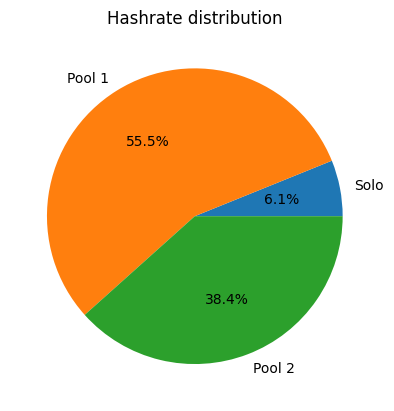

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(12345)

# ----------------------
# 0) Paramètres

# Lambda_total : intensité totale de minage (somme des λ_i)
# N_miners : nombre de mineurs hétérogènes
# alpha : paramètre Dirichlet pour répartir Λ_total
# b : reward par bloc
# eta1, eta2 : aversion au risque des managers
# y1, y2 : richesse initiale des managers
Lambda_total = 6.0
N_miners = 20        # je peux monter, mais le temps explose
alpha = 1.0
b = 3.125

eta1 = 0.01
eta2 = 0.02
y1 = 3
y2 = 5

# Mineurs : tirage des hashrates λ_i et des γ_i dans (0,1)
lambdas = rng.dirichlet(alpha * np.ones(N_miners)) * Lambda_total
theta_risk = rng.uniform(0.0, 1, size=N_miners)  # θ_i interprété comme γ_i


# ----------------------
# 1) Paramètres des "actifs" pour un mineur i

# À partir de (f1,d1,f2,d2), je construis les 3 profils :
#  - solo
#  - pool 1
#  - pool 2
# et je récupère (μ, Var) pour chacun.
def compute_asset_params_for_miner(i, f1, d1, f2, d2):
    """
    Actifs :
      k=0 : solo,  k=1 : pool 1,  k=2 : pool 2

    Pour le mineur i :
        λ_{i,0} = λ_i
        λ_{i,1} = λ_i / d1
        λ_{i,2} = λ_i / d2

        b_0 = b
        b_1 = d1 * b * (1 - f1)
        b_2 = d2 * b * (1 - f2)

    On renvoie :
        mu_vec[k]  = E[payoff_{i,k}]   = λ_{i,k} b_k
        var_vec[k] = Var[payoff_{i,k}] = λ_{i,k} b_k^2
    """
    lam = lambdas[i]

    lam0 = lam
    lam1 = lam / d1
    lam2 = lam / d2

    b0 = b
    b1 = d1 * b * (1 - f1)
    b2 = d2 * b * (1 - f2)

    mu_vec = np.array([lam0 * b0,    lam1 * b1,      lam2 * b2])
    var_vec = np.array([lam0 * b0**2, lam1 * b1**2,  lam2 * b2**2])
    return mu_vec, var_vec


# ----------------------
# 2) Poids optimaux du mineur (w0,w1,w2)

# Ici je force les mineurs à faire un vrai trade-off mean–variance
# sur une grille (w1,w2), avec w0 = 1 - w1 - w2.
weight_grid = np.linspace(0.0, 1.0, 21)   # 0,0.05,...,1

def miner_optimal_weights(i, f1, d1, f2, d2):
    # μ et Var des 3 “actifs” pour le mineur i
    mu_vec, var_vec = compute_asset_params_for_miner(i, f1, d1, f2, d2)
    gamma_i = float(theta_risk[i])

    best_val = -1e18
    best_w = (1.0, 0.0, 0.0)  # par défaut : tout en solo

    # balayage discret des poids (w1,w2), w0 est déterminé par la contrainte de somme à 1
    for w1 in weight_grid:
        for w2 in weight_grid:
            w0 = 1.0 - w1 - w2
            if w0 < 0 or w0 > 1:
                continue
            w = np.array([w0, w1, w2])

            mean_val = float(np.dot(w, mu_vec))
            # variance de portefeuille quadratique (style Markowitz, actifs indépendants)
            var_val  = float(np.dot(w**2, var_vec))

            # critère mean–variance : E - γ Var
            obj = mean_val - gamma_i * var_val

            if obj > best_val:
                best_val = obj
                best_w = (w0, w1, w2)

    return best_w


# ----------------------
# 3) DataFrame mineurs + hashrates H_solo, H1, H2

# Pour un profil de contrats (f1,d1,f2,d2), je laisse les mineurs
# réoptimiser leurs poids, puis j’agrège les hashrates.
def build_miners_df_for_contracts(f1, d1, f2, d2):
    """
    Pour un profil de contrats (f1,d1) et (f2,d2),
    - calcule pour chaque mineur i ses poids optimaux (w0,w1,w2),
    - construit un DataFrame descriptif,
    - agrège les hashrates H_solo, H1, H2.
    """
    records = []
    for i in range(N_miners):
        mu_vec, var_vec = compute_asset_params_for_miner(i, f1, d1, f2, d2)
        w0, w1, w2 = miner_optimal_weights(i, f1, d1, f2, d2)
        records.append({
            "miner_id": i,
            "lambda_i": lambdas[i],
            "gamma_i": theta_risk[i],
            "E_solo": mu_vec[0],
            "Var_solo": var_vec[0],
            "E_pool1": mu_vec[1],
            "Var_pool1": var_vec[1],
            "E_pool2": mu_vec[2],
            "Var_pool2": var_vec[2],
            "w0": w0,
            "w1": w1,
            "w2": w2,
        })

    df = pd.DataFrame(records)

    # hashrate effectif sur chaque “actif”
    H_solo = float((df["lambda_i"] * df["w0"]).sum())
    H1     = float((df["lambda_i"] * df["w1"]).sum())
    H2     = float((df["lambda_i"] * df["w2"]).sum())

    return df, H_solo, H1, H2


# ----------------------
# 4) Utilité des managers

# J_manager = E[Y] - eta Var[Y]
# Je reprends les formules E[Y], Var[Y] (voir ce que j'ai mis dans l'article), avec µ = H/d.
def manager_utility(H, f, d, eta, y0):
    """
    J_manager = E[Y] - eta Var[Y]

    E[Y] et Var[Y] proviennent du modèle mean–variance pour le surplus du pool manager,
    avec intensité µ = H / d et reward structure (b, f, d), pour un horizon T=1.

    Si H = 0 : pas de mineurs, utilité = y0.
    """
    if H <= 1e-12:
        return y0

    mu = H / d
    b_val = b  # cohérence avec la partie mineurs

    term_E = mu * (b_val * d / (1 + d)) * (f * (1 + d) - d)
    E_Y = y0 + term_E

    term1 = b_val**2 * (1 - f)**2 * d**2 / (1 + d)
    term2 = b_val**2 * d * (1 - (1 - f) * d)**2 / (1 + d)
    Var_Y = mu * (term1 + term2)

    return E_Y - eta * Var_Y


# ----------------------
# 5) Best-responses en (f,d) + Nash discret

# Je définis les grilles de stratégies pour (f,d) et je cherche un point fixe
# des best responses des deux managers.
f_grid = np.linspace(0.0, 0.4, 50)
d_grid = np.linspace(0.0, 1.0, 50)

def admissible(f, d):
    """
    Condition de drift positif (Eq 6 page 4 du PDF).
    Le pool doit être rentable en espérance pour le manager.
    Condition: f * (1 + delta) > delta
    """
    if d <= 0: 
        return False
    
    # petite marge numérique pour éviter les égalités pile
    lhs = f * (1.0 + d)
    rhs = d
    return lhs > rhs + 1e-9


def best_response_manager(j, other_contract):
    """
    Best response du manager j ∈ {1,2} au contrat de l'autre manager.

    Entrée :
      j = 1 ou 2
      other_contract = (f_other, d_other)

    Sortie :
      f_best, d_best : contrat optimal sur la grille
      J_best         : utilité maximale du manager j
      (H_solo, H1, H2) : hashrates agrégés sous ce profil de contrats
    """
    f_other, d_other = other_contract

    best_J = -1e30
    best_f = None
    best_d = None
    best_H = (0.0, 0.0, 0.0)

    # balayage de toute la grille admissible (f,d) pour ce manager
    for f in f_grid:
        for d in d_grid:
            if not admissible(f, d):
                continue

            if j == 1:
                f1, d1 = f, d
                f2, d2 = f_other, d_other
            else:
                f1, d1 = f_other, d_other
                f2, d2 = f, d

            # réaction des mineurs à ce couple de contrats
            _, H_solo, H1, H2 = build_miners_df_for_contracts(f1, d1, f2, d2)

            # utilité du manager j sous ce profil
            if j == 1:
                J = manager_utility(H1, f1, d1, eta1, y1)
            else:
                J = manager_utility(H2, f2, d2, eta2, y2)

            # mise à jour du best response
            if J > best_J:
                best_J = J
                best_f = f
                best_d = d
                best_H = (H_solo, H1, H2)

    return best_f, best_d, best_J, best_H


def solve_nash_fd(start_f1=0.05, start_d1=0.1,
                  start_f2=0.05, start_d2=0.1,
                  max_iter=10, tol=1e-3):
    """
    Itère les best responses des deux managers en (f,d) sur des grilles,
    afin d'approcher un équilibre de Nash (discret) en (f1,d1,f2,d2).
    """
    f1, d1 = start_f1, start_d1
    f2, d2 = start_f2, start_d2
    history = []

    for it in range(max_iter):
        # Best response manager 1 à (f2,d2)
        br1_f, br1_d, br1_J, br1_H = best_response_manager(1, (f2, d2))
        # Best response manager 2 à (br1_f,br1_d)
        br2_f, br2_d, br2_J, br2_H = best_response_manager(2, (br1_f, br1_d))

        history.append({
            "iter": it,
            "f1": br1_f, "d1": br1_d, "J1": br1_J,
            "H_solo_br1": br1_H[0], "H1_br1": br1_H[1], "H2_br1": br1_H[2],
            "f2": br2_f, "d2": br2_d, "J2": br2_J,
            "H_solo_br2": br2_H[0], "H1_br2": br2_H[1], "H2_br2": br2_H[2],
        })

        # critère de convergence --> les best responses ne bougent plus
        if (abs(br1_f - f1) < tol and abs(br1_d - d1) < tol and
            abs(br2_f - f2) < tol and abs(br2_d - d2) < tol):
            f1, d1, f2, d2 = br1_f, br1_d, br2_f, br2_d
            break

        # mise à jour du profil pour l'itération suivante
        f1, d1, f2, d2 = br1_f, br1_d, br2_f, br2_d

    # Allocation finale cohérente avec le dernier profil de contrats
    df_final, H_solo, H1, H2 = build_miners_df_for_contracts(f1, d1, f2, d2)
    J1_final = manager_utility(H1, f1, d1, eta1, y1)
    J2_final = manager_utility(H2, f2, d2, eta2, y2)

    return {
        "f1": f1, "d1": d1,
        "f2": f2, "d2": d2,
        "H_solo": H_solo,
        "H1": H1, "H2": H2,
        "J1": J1_final, "J2": J2_final,
        "history": history,
        "df_miners": df_final,
    }


# -------------------
# Je lance la procédure de best responses et j’affiche le Nash trouvé.
if __name__ == "__main__":
    result = solve_nash_fd()
    print(
        "f1 =", result["f1"],
        "d1 =", result["d1"],
        "f2 =", result["f2"],
        "d2 =", result["d2"],
    )
    print(
        "H_solo =", result["H_solo"],
        "H1 =", result["H1"],
        "H2 =", result["H2"],
    )
    print(
        "J1 =", result["J1"],
        "J2 =", result["J2"],
    )

# Camembert de la répartition de hashrate
labels = ["Solo", "Pool 1", "Pool 2"]
sizes = [result["H_solo"], result["H1"], result["H2"]]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct="%1.1f%%")
ax.set_title("Hashrate distribution")
plt.show()


Dans le code suivant j'ai modifiié les paramètres initiaux (f_1,f_2,d_1,d_2 )de la fonction solve_nash_fd() pour voir si je reconverge bien vers le même équilibre de Nash

f1 = 0.10612244897959185 d1 = 0.02040816326530612 f2 = 0.1142857142857143 d2 = 0.02040816326530612
H_solo = 0.3672980806936408 H1 = 3.3307378128347316 H2 = 2.3019641064716256
J1 = 3.5839742919565216 J2 = 5.2463776016197095


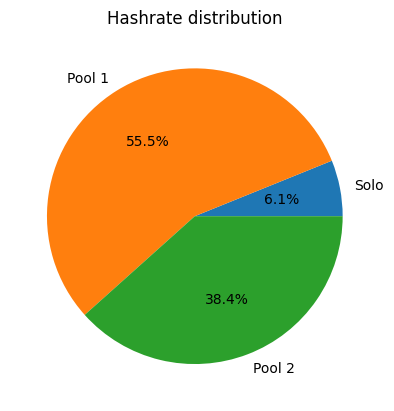

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(12345)

# ----------------------
# 0) Paramètres

# Lambda_total : intensité totale de minage (somme des λ_i)
# N_miners : nombre de mineurs hétérogènes
# alpha : paramètre Dirichlet pour répartir Λ_total
# b : reward par bloc
# eta1, eta2 : aversion au risque des managers
# y1, y2 : richesse initiale des managers
Lambda_total = 6.0
N_miners = 20        # je peux monter, mais le temps explose
alpha = 1.0
b = 3.125

eta1 = 0.01
eta2 = 0.02
y1 = 3
y2 = 5

# Mineurs : tirage des hashrates λ_i et des γ_i dans (0,1)
lambdas = rng.dirichlet(alpha * np.ones(N_miners)) * Lambda_total
theta_risk = rng.uniform(0.0, 1, size=N_miners)  # θ_i interprété comme γ_i


# ----------------------
# 1) Paramètres des "actifs" pour un mineur i

# À partir de (f1,d1,f2,d2), je construis les 3 profils :
#  - solo
#  - pool 1
#  - pool 2
# et je récupère (μ, Var) pour chacun.
def compute_asset_params_for_miner(i, f1, d1, f2, d2):
    """
    Actifs :
      k=0 : solo,  k=1 : pool 1,  k=2 : pool 2

    Pour le mineur i :
        λ_{i,0} = λ_i
        λ_{i,1} = λ_i / d1
        λ_{i,2} = λ_i / d2

        b_0 = b
        b_1 = d1 * b * (1 - f1)
        b_2 = d2 * b * (1 - f2)

    On renvoie :
        mu_vec[k]  = E[payoff_{i,k}]   = λ_{i,k} b_k
        var_vec[k] = Var[payoff_{i,k}] = λ_{i,k} b_k^2
    """
    lam = lambdas[i]

    lam0 = lam
    lam1 = lam / d1
    lam2 = lam / d2

    b0 = b
    b1 = d1 * b * (1 - f1)
    b2 = d2 * b * (1 - f2)

    mu_vec = np.array([lam0 * b0,    lam1 * b1,      lam2 * b2])
    var_vec = np.array([lam0 * b0**2, lam1 * b1**2,  lam2 * b2**2])
    return mu_vec, var_vec


# ----------------------
# 2) Poids optimaux du mineur (w0,w1,w2)

# Ici je force les mineurs à faire un vrai trade-off mean–variance
# sur une grille (w1,w2), avec w0 = 1 - w1 - w2.
weight_grid = np.linspace(0.0, 1.0, 21)   # 0,0.05,...,1

def miner_optimal_weights(i, f1, d1, f2, d2):
    # μ et Var des 3 “actifs” pour le mineur i
    mu_vec, var_vec = compute_asset_params_for_miner(i, f1, d1, f2, d2)
    gamma_i = float(theta_risk[i])

    best_val = -1e18
    best_w = (1.0, 0.0, 0.0)  # par défaut : tout en solo

    # balayage discret des poids (w1,w2), w0 est déterminé par la contrainte de somme à 1
    for w1 in weight_grid:
        for w2 in weight_grid:
            w0 = 1.0 - w1 - w2
            if w0 < 0 or w0 > 1:
                continue
            w = np.array([w0, w1, w2])

            mean_val = float(np.dot(w, mu_vec))
            # variance de portefeuille quadratique (style Markowitz, actifs indépendants)
            var_val  = float(np.dot(w**2, var_vec))

            # critère mean–variance : E - γ Var
            obj = mean_val - gamma_i * var_val

            if obj > best_val:
                best_val = obj
                best_w = (w0, w1, w2)

    return best_w


# ----------------------
# 3) DataFrame mineurs + hashrates H_solo, H1, H2

# Pour un profil de contrats (f1,d1,f2,d2), je laisse les mineurs
# réoptimiser leurs poids, puis j’agrège les hashrates.
def build_miners_df_for_contracts(f1, d1, f2, d2):
    """
    Pour un profil de contrats (f1,d1) et (f2,d2),
    - calcule pour chaque mineur i ses poids optimaux (w0,w1,w2),
    - construit un DataFrame descriptif,
    - agrège les hashrates H_solo, H1, H2.
    """
    records = []
    for i in range(N_miners):
        mu_vec, var_vec = compute_asset_params_for_miner(i, f1, d1, f2, d2)
        w0, w1, w2 = miner_optimal_weights(i, f1, d1, f2, d2)
        records.append({
            "miner_id": i,
            "lambda_i": lambdas[i],
            "gamma_i": theta_risk[i],
            "E_solo": mu_vec[0],
            "Var_solo": var_vec[0],
            "E_pool1": mu_vec[1],
            "Var_pool1": var_vec[1],
            "E_pool2": mu_vec[2],
            "Var_pool2": var_vec[2],
            "w0": w0,
            "w1": w1,
            "w2": w2,
        })

    df = pd.DataFrame(records)

    # hashrate effectif sur chaque “actif”
    H_solo = float((df["lambda_i"] * df["w0"]).sum())
    H1     = float((df["lambda_i"] * df["w1"]).sum())
    H2     = float((df["lambda_i"] * df["w2"]).sum())

    return df, H_solo, H1, H2


# ----------------------
# 4) Utilité des managers

# J_manager = E[Y] - eta Var[Y]
# Je reprends les formules E[Y], Var[Y] (voir ce que j'ai mis dans l'article), avec µ = H/d.
def manager_utility(H, f, d, eta, y0):
    """
    J_manager = E[Y] - eta Var[Y]

    E[Y] et Var[Y] proviennent du modèle mean–variance pour le surplus du pool manager,
    avec intensité µ = H / d et reward structure (b, f, d), pour un horizon T=1.

    Si H = 0 : pas de mineurs, utilité = y0.
    """
    if H <= 1e-12:
        return y0

    mu = H / d
    b_val = b  # cohérence avec la partie mineurs

    term_E = mu * (b_val * d / (1 + d)) * (f * (1 + d) - d)
    E_Y = y0 + term_E

    term1 = b_val**2 * (1 - f)**2 * d**2 / (1 + d)
    term2 = b_val**2 * d * (1 - (1 - f) * d)**2 / (1 + d)
    Var_Y = mu * (term1 + term2)

    return E_Y - eta * Var_Y


# ----------------------
# 5) Best-responses en (f,d) + Nash discret

# Je définis les grilles de stratégies pour (f,d) et je cherche un point fixe
# des best responses des deux managers.
f_grid = np.linspace(0.0, 0.4, 50)
d_grid = np.linspace(0.0, 1.0, 50)

def admissible(f, d):
    """
    Condition de drift positif (Eq 6 page 4 du PDF).
    Le pool doit être rentable en espérance pour le manager.
    Condition: f * (1 + delta) > delta
    """
    if d <= 0: 
        return False
    
    # petite marge numérique pour éviter les égalités pile
    lhs = f * (1.0 + d)
    rhs = d
    return lhs > rhs + 1e-9


def best_response_manager(j, other_contract):
    """
    Best response du manager j ∈ {1,2} au contrat de l'autre manager.

    Entrée :
      j = 1 ou 2
      other_contract = (f_other, d_other)

    Sortie :
      f_best, d_best : contrat optimal sur la grille
      J_best         : utilité maximale du manager j
      (H_solo, H1, H2) : hashrates agrégés sous ce profil de contrats
    """
    f_other, d_other = other_contract

    best_J = -1e30
    best_f = None
    best_d = None
    best_H = (0.0, 0.0, 0.0)

    # balayage de toute la grille admissible (f,d) pour ce manager
    for f in f_grid:
        for d in d_grid:
            if not admissible(f, d):
                continue

            if j == 1:
                f1, d1 = f, d
                f2, d2 = f_other, d_other
            else:
                f1, d1 = f_other, d_other
                f2, d2 = f, d

            # réaction des mineurs à ce couple de contrats
            _, H_solo, H1, H2 = build_miners_df_for_contracts(f1, d1, f2, d2)

            # utilité du manager j sous ce profil
            if j == 1:
                J = manager_utility(H1, f1, d1, eta1, y1)
            else:
                J = manager_utility(H2, f2, d2, eta2, y2)

            # mise à jour du best response
            if J > best_J:
                best_J = J
                best_f = f
                best_d = d
                best_H = (H_solo, H1, H2)

    return best_f, best_d, best_J, best_H


def solve_nash_fd(start_f1=0.10, start_d1=0.2,
                  start_f2=0.10, start_d2=0.2,
                  max_iter=10, tol=1e-3):
    """
    Itère les best responses des deux managers en (f,d) sur des grilles,
    afin d'approcher un équilibre de Nash (discret) en (f1,d1,f2,d2).
    """
    f1, d1 = start_f1, start_d1
    f2, d2 = start_f2, start_d2
    history = []

    for it in range(max_iter):
        # Best response manager 1 à (f2,d2)
        br1_f, br1_d, br1_J, br1_H = best_response_manager(1, (f2, d2))
        # Best response manager 2 à (br1_f,br1_d)
        br2_f, br2_d, br2_J, br2_H = best_response_manager(2, (br1_f, br1_d))

        history.append({
            "iter": it,
            "f1": br1_f, "d1": br1_d, "J1": br1_J,
            "H_solo_br1": br1_H[0], "H1_br1": br1_H[1], "H2_br1": br1_H[2],
            "f2": br2_f, "d2": br2_d, "J2": br2_J,
            "H_solo_br2": br2_H[0], "H1_br2": br2_H[1], "H2_br2": br2_H[2],
        })

        # critère de convergence --> les best responses ne bougent plus
        if (abs(br1_f - f1) < tol and abs(br1_d - d1) < tol and
            abs(br2_f - f2) < tol and abs(br2_d - d2) < tol):
            f1, d1, f2, d2 = br1_f, br1_d, br2_f, br2_d
            break

        # mise à jour du profil pour l'itération suivante
        f1, d1, f2, d2 = br1_f, br1_d, br2_f, br2_d

    # Allocation finale cohérente avec le dernier profil de contrats
    df_final, H_solo, H1, H2 = build_miners_df_for_contracts(f1, d1, f2, d2)
    J1_final = manager_utility(H1, f1, d1, eta1, y1)
    J2_final = manager_utility(H2, f2, d2, eta2, y2)

    return {
        "f1": f1, "d1": d1,
        "f2": f2, "d2": d2,
        "H_solo": H_solo,
        "H1": H1, "H2": H2,
        "J1": J1_final, "J2": J2_final,
        "history": history,
        "df_miners": df_final,
    }


# -------------------
# Je lance la procédure de best responses et j’affiche le Nash trouvé.
if __name__ == "__main__":
    result = solve_nash_fd()
    print(
        "f1 =", result["f1"],
        "d1 =", result["d1"],
        "f2 =", result["f2"],
        "d2 =", result["d2"],
    )
    print(
        "H_solo =", result["H_solo"],
        "H1 =", result["H1"],
        "H2 =", result["H2"],
    )
    print(
        "J1 =", result["J1"],
        "J2 =", result["J2"],
    )

# Camembert de la répartition de hashrate
labels = ["Solo", "Pool 1", "Pool 2"]
sizes = [result["H_solo"], result["H1"], result["H2"]]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct="%1.1f%%")
ax.set_title("Hashrate distribution")
plt.show()


on voit que dans les 2 cas on reconverge vers le même équilibre --> OK 

## Nash Equilibrium: Exemple 2

f1 = 0.0979591836734694 d1 = 0.02040816326530612 f2 = 0.0979591836734694 d2 = 0.02040816326530612
H_solo = 0.2774994011336336 H1 = 2.7676014687902994 H2 = 2.954899130076065
J1 = 3.4146455775561506 J2 = 2.3872721495989926


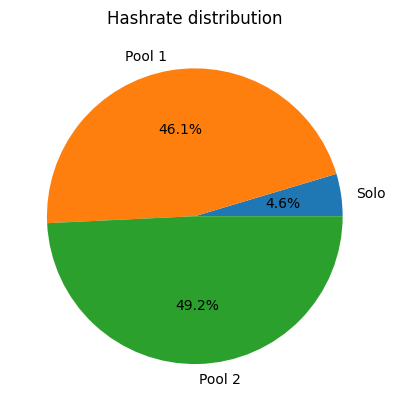

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(12345)

# ----------------------
# 0) Paramètres

# Lambda_total : intensité totale de minage (somme des λ_i)
# N_miners : nombre de mineurs hétérogènes
# alpha : paramètre Dirichlet pour répartir Λ_total
# b : reward par bloc
# eta1, eta2 : aversion au risque des managers
# y1, y2 : richesse initiale des managers
Lambda_total = 6.0
N_miners = 20        # je peux monter, mais le temps explose
alpha = 1.0
b = 3.125

eta1 = 0.01
eta2 = 0.012
y1 = 3
y2 = 2

# Mineurs : tirage des hashrates λ_i et des γ_i dans (0,1)
lambdas = rng.dirichlet(alpha * np.ones(N_miners)) * Lambda_total
theta_risk = rng.uniform(0.0, 1, size=N_miners)  # θ_i interprété comme γ_i


# ----------------------
# 1) Paramètres des "actifs" pour un mineur i

# À partir de (f1,d1,f2,d2), je construis les 3 profils :
#  - solo
#  - pool 1
#  - pool 2
# et je récupère (μ, Var) pour chacun.
def compute_asset_params_for_miner(i, f1, d1, f2, d2):
    """
    Actifs :
      k=0 : solo,  k=1 : pool 1,  k=2 : pool 2

    Pour le mineur i :
        λ_{i,0} = λ_i
        λ_{i,1} = λ_i / d1
        λ_{i,2} = λ_i / d2

        b_0 = b
        b_1 = d1 * b * (1 - f1)
        b_2 = d2 * b * (1 - f2)

    On renvoie :
        mu_vec[k]  = E[payoff_{i,k}]   = λ_{i,k} b_k
        var_vec[k] = Var[payoff_{i,k}] = λ_{i,k} b_k^2
    """
    lam = lambdas[i]

    lam0 = lam
    lam1 = lam / d1
    lam2 = lam / d2

    b0 = b
    b1 = d1 * b * (1 - f1)
    b2 = d2 * b * (1 - f2)

    mu_vec = np.array([lam0 * b0,    lam1 * b1,      lam2 * b2])
    var_vec = np.array([lam0 * b0**2, lam1 * b1**2,  lam2 * b2**2])
    return mu_vec, var_vec


# ----------------------
# 2) Poids optimaux du mineur (w0,w1,w2)

# Ici je force les mineurs à faire un vrai trade-off mean–variance
# sur une grille (w1,w2), avec w0 = 1 - w1 - w2.
weight_grid = np.linspace(0.0, 1.0, 21)   # 0,0.05,...,1

def miner_optimal_weights(i, f1, d1, f2, d2):
    # μ et Var des 3 “actifs” pour le mineur i
    mu_vec, var_vec = compute_asset_params_for_miner(i, f1, d1, f2, d2)
    gamma_i = float(theta_risk[i])

    best_val = -1e18
    best_w = (1.0, 0.0, 0.0)  # par défaut : tout en solo

    # balayage discret des poids (w1,w2), w0 est déterminé par la contrainte de somme à 1
    for w1 in weight_grid:
        for w2 in weight_grid:
            w0 = 1.0 - w1 - w2
            if w0 < 0 or w0 > 1:
                continue
            w = np.array([w0, w1, w2])

            mean_val = float(np.dot(w, mu_vec))
            # variance de portefeuille quadratique (style Markowitz, actifs indépendants)
            var_val  = float(np.dot(w**2, var_vec))

            # critère mean–variance : E - γ Var
            obj = mean_val - gamma_i * var_val

            if obj > best_val:
                best_val = obj
                best_w = (w0, w1, w2)

    return best_w


# ----------------------
# 3) DataFrame mineurs + hashrates H_solo, H1, H2

# Pour un profil de contrats (f1,d1,f2,d2), je laisse les mineurs
# réoptimiser leurs poids, puis j’agrège les hashrates.
def build_miners_df_for_contracts(f1, d1, f2, d2):
    """
    Pour un profil de contrats (f1,d1) et (f2,d2),
    - calcule pour chaque mineur i ses poids optimaux (w0,w1,w2),
    - construit un DataFrame descriptif,
    - agrège les hashrates H_solo, H1, H2.
    """
    records = []
    for i in range(N_miners):
        mu_vec, var_vec = compute_asset_params_for_miner(i, f1, d1, f2, d2)
        w0, w1, w2 = miner_optimal_weights(i, f1, d1, f2, d2)
        records.append({
            "miner_id": i,
            "lambda_i": lambdas[i],
            "gamma_i": theta_risk[i],
            "E_solo": mu_vec[0],
            "Var_solo": var_vec[0],
            "E_pool1": mu_vec[1],
            "Var_pool1": var_vec[1],
            "E_pool2": mu_vec[2],
            "Var_pool2": var_vec[2],
            "w0": w0,
            "w1": w1,
            "w2": w2,
        })

    df = pd.DataFrame(records)

    # hashrate effectif sur chaque “actif”
    H_solo = float((df["lambda_i"] * df["w0"]).sum())
    H1     = float((df["lambda_i"] * df["w1"]).sum())
    H2     = float((df["lambda_i"] * df["w2"]).sum())

    return df, H_solo, H1, H2


# ----------------------
# 4) Utilité des managers

# J_manager = E[Y] - eta Var[Y]
# Je reprends les formules E[Y], Var[Y] (voir ce que j'ai mis dans l'article), avec µ = H/d.
def manager_utility(H, f, d, eta, y0):
    """
    J_manager = E[Y] - eta Var[Y]

    E[Y] et Var[Y] proviennent du modèle mean–variance pour le surplus du pool manager,
    avec intensité µ = H / d et reward structure (b, f, d), pour un horizon T=1.

    Si H = 0 : pas de mineurs, utilité = y0.
    """
    if H <= 1e-12:
        return y0

    mu = H / d
    b_val = b  # cohérence avec la partie mineurs

    term_E = mu * (b_val * d / (1 + d)) * (f * (1 + d) - d)
    E_Y = y0 + term_E

    term1 = b_val**2 * (1 - f)**2 * d**2 / (1 + d)
    term2 = b_val**2 * d * (1 - (1 - f) * d)**2 / (1 + d)
    Var_Y = mu * (term1 + term2)

    return E_Y - eta * Var_Y


# ----------------------
# 5) Best-responses en (f,d) + Nash discret

# Je définis les grilles de stratégies pour (f,d) et je cherche un point fixe
# des best responses des deux managers.
f_grid = np.linspace(0.0, 0.4, 50)
d_grid = np.linspace(0.0, 1.0, 50)

def admissible(f, d):
    """
    Condition de drift positif (Eq 6 page 4 du PDF).
    Le pool doit être rentable en espérance pour le manager.
    Condition: f * (1 + delta) > delta
    """
    if d <= 0: 
        return False
    
    # petite marge numérique pour éviter les égalités pile
    lhs = f * (1.0 + d)
    rhs = d
    return lhs > rhs + 1e-9


def best_response_manager(j, other_contract):
    """
    Best response du manager j ∈ {1,2} au contrat de l'autre manager.

    Entrée :
      j = 1 ou 2
      other_contract = (f_other, d_other)

    Sortie :
      f_best, d_best : contrat optimal sur la grille
      J_best         : utilité maximale du manager j
      (H_solo, H1, H2) : hashrates agrégés sous ce profil de contrats
    """
    f_other, d_other = other_contract

    best_J = -1e30
    best_f = None
    best_d = None
    best_H = (0.0, 0.0, 0.0)

    # balayage de toute la grille admissible (f,d) pour ce manager
    for f in f_grid:
        for d in d_grid:
            if not admissible(f, d):
                continue

            if j == 1:
                f1, d1 = f, d
                f2, d2 = f_other, d_other
            else:
                f1, d1 = f_other, d_other
                f2, d2 = f, d

            # réaction des mineurs à ce couple de contrats
            _, H_solo, H1, H2 = build_miners_df_for_contracts(f1, d1, f2, d2)

            # utilité du manager j sous ce profil
            if j == 1:
                J = manager_utility(H1, f1, d1, eta1, y1)
            else:
                J = manager_utility(H2, f2, d2, eta2, y2)

            # mise à jour du best response
            if J > best_J:
                best_J = J
                best_f = f
                best_d = d
                best_H = (H_solo, H1, H2)

    return best_f, best_d, best_J, best_H


def solve_nash_fd(start_f1=0.05, start_d1=0.3,
                  start_f2=0.05, start_d2=0.3,
                  max_iter=10, tol=1e-3):
    """
    Itère les best responses des deux managers en (f,d) sur des grilles,
    afin d'approcher un équilibre de Nash (discret) en (f1,d1,f2,d2).
    """
    f1, d1 = start_f1, start_d1
    f2, d2 = start_f2, start_d2
    history = []

    for it in range(max_iter):
        # Best response manager 1 à (f2,d2)
        br1_f, br1_d, br1_J, br1_H = best_response_manager(1, (f2, d2))
        # Best response manager 2 à (br1_f,br1_d)
        br2_f, br2_d, br2_J, br2_H = best_response_manager(2, (br1_f, br1_d))

        history.append({
            "iter": it,
            "f1": br1_f, "d1": br1_d, "J1": br1_J,
            "H_solo_br1": br1_H[0], "H1_br1": br1_H[1], "H2_br1": br1_H[2],
            "f2": br2_f, "d2": br2_d, "J2": br2_J,
            "H_solo_br2": br2_H[0], "H1_br2": br2_H[1], "H2_br2": br2_H[2],
        })

        # critère de convergence --> les best responses ne bougent plus
        if (abs(br1_f - f1) < tol and abs(br1_d - d1) < tol and
            abs(br2_f - f2) < tol and abs(br2_d - d2) < tol):
            f1, d1, f2, d2 = br1_f, br1_d, br2_f, br2_d
            break

        # mise à jour du profil pour l'itération suivante
        f1, d1, f2, d2 = br1_f, br1_d, br2_f, br2_d

    # Allocation finale cohérente avec le dernier profil de contrats
    df_final, H_solo, H1, H2 = build_miners_df_for_contracts(f1, d1, f2, d2)
    J1_final = manager_utility(H1, f1, d1, eta1, y1)
    J2_final = manager_utility(H2, f2, d2, eta2, y2)

    return {
        "f1": f1, "d1": d1,
        "f2": f2, "d2": d2,
        "H_solo": H_solo,
        "H1": H1, "H2": H2,
        "J1": J1_final, "J2": J2_final,
        "history": history,
        "df_miners": df_final,
    }


# -------------------
# Je lance la procédure de best responses et j’affiche le Nash trouvé.
if __name__ == "__main__":
    result = solve_nash_fd()
    print(
        "f1 =", result["f1"],
        "d1 =", result["d1"],
        "f2 =", result["f2"],
        "d2 =", result["d2"],
    )
    print(
        "H_solo =", result["H_solo"],
        "H1 =", result["H1"],
        "H2 =", result["H2"],
    )
    print(
        "J1 =", result["J1"],
        "J2 =", result["J2"],
    )

# Camembert de la répartition de hashrate
labels = ["Solo", "Pool 1", "Pool 2"]
sizes = [result["H_solo"], result["H1"], result["H2"]]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct="%1.1f%%")
ax.set_title("Hashrate distribution")
plt.show()


check en changeant les paramètres initiaux de la fonction solve_nash_fd

f1 = 0.0979591836734694 d1 = 0.02040816326530612 f2 = 0.0979591836734694 d2 = 0.02040816326530612
H_solo = 0.2774994011336336 H1 = 2.7676014687902994 H2 = 2.954899130076065
J1 = 3.4146455775561506 J2 = 2.3872721495989926


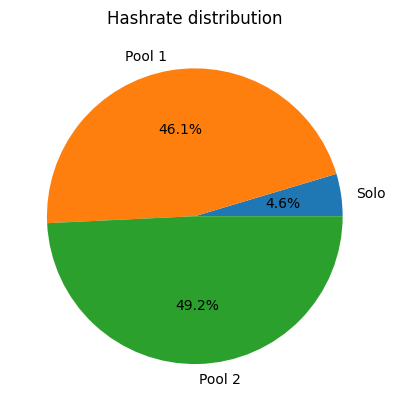

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(12345)

# ----------------------
# 0) Paramètres

# Lambda_total : intensité totale de minage (somme des λ_i)
# N_miners : nombre de mineurs hétérogènes
# alpha : paramètre Dirichlet pour répartir Λ_total
# b : reward par bloc
# eta1, eta2 : aversion au risque des managers
# y1, y2 : richesse initiale des managers
Lambda_total = 6.0
N_miners = 20        # je peux monter, mais le temps explose
alpha = 1.0
b = 3.125

eta1 = 0.01
eta2 = 0.012
y1 = 3
y2 = 2

# Mineurs : tirage des hashrates λ_i et des γ_i dans (0,1)
lambdas = rng.dirichlet(alpha * np.ones(N_miners)) * Lambda_total
theta_risk = rng.uniform(0.0, 1, size=N_miners)  # θ_i interprété comme γ_i


# ----------------------
# 1) Paramètres des "actifs" pour un mineur i

# À partir de (f1,d1,f2,d2), je construis les 3 profils :
#  - solo
#  - pool 1
#  - pool 2
# et je récupère (μ, Var) pour chacun.
def compute_asset_params_for_miner(i, f1, d1, f2, d2):
    """
    Actifs :
      k=0 : solo,  k=1 : pool 1,  k=2 : pool 2

    Pour le mineur i :
        λ_{i,0} = λ_i
        λ_{i,1} = λ_i / d1
        λ_{i,2} = λ_i / d2

        b_0 = b
        b_1 = d1 * b * (1 - f1)
        b_2 = d2 * b * (1 - f2)

    On renvoie :
        mu_vec[k]  = E[payoff_{i,k}]   = λ_{i,k} b_k
        var_vec[k] = Var[payoff_{i,k}] = λ_{i,k} b_k^2
    """
    lam = lambdas[i]

    lam0 = lam
    lam1 = lam / d1
    lam2 = lam / d2

    b0 = b
    b1 = d1 * b * (1 - f1)
    b2 = d2 * b * (1 - f2)

    mu_vec = np.array([lam0 * b0,    lam1 * b1,      lam2 * b2])
    var_vec = np.array([lam0 * b0**2, lam1 * b1**2,  lam2 * b2**2])
    return mu_vec, var_vec


# ----------------------
# 2) Poids optimaux du mineur (w0,w1,w2)

# Ici je force les mineurs à faire un vrai trade-off mean–variance
# sur une grille (w1,w2), avec w0 = 1 - w1 - w2.
weight_grid = np.linspace(0.0, 1.0, 21)   # 0,0.05,...,1

def miner_optimal_weights(i, f1, d1, f2, d2):
    # μ et Var des 3 “actifs” pour le mineur i
    mu_vec, var_vec = compute_asset_params_for_miner(i, f1, d1, f2, d2)
    gamma_i = float(theta_risk[i])

    best_val = -1e18
    best_w = (1.0, 0.0, 0.0)  # par défaut : tout en solo

    # balayage discret des poids (w1,w2), w0 est déterminé par la contrainte de somme à 1
    for w1 in weight_grid:
        for w2 in weight_grid:
            w0 = 1.0 - w1 - w2
            if w0 < 0 or w0 > 1:
                continue
            w = np.array([w0, w1, w2])

            mean_val = float(np.dot(w, mu_vec))
            # variance de portefeuille quadratique (style Markowitz, actifs indépendants)
            var_val  = float(np.dot(w**2, var_vec))

            # critère mean–variance : E - γ Var
            obj = mean_val - gamma_i * var_val

            if obj > best_val:
                best_val = obj
                best_w = (w0, w1, w2)

    return best_w


# ----------------------
# 3) DataFrame mineurs + hashrates H_solo, H1, H2

# Pour un profil de contrats (f1,d1,f2,d2), je laisse les mineurs
# réoptimiser leurs poids, puis j’agrège les hashrates.
def build_miners_df_for_contracts(f1, d1, f2, d2):
    """
    Pour un profil de contrats (f1,d1) et (f2,d2),
    - calcule pour chaque mineur i ses poids optimaux (w0,w1,w2),
    - construit un DataFrame descriptif,
    - agrège les hashrates H_solo, H1, H2.
    """
    records = []
    for i in range(N_miners):
        mu_vec, var_vec = compute_asset_params_for_miner(i, f1, d1, f2, d2)
        w0, w1, w2 = miner_optimal_weights(i, f1, d1, f2, d2)
        records.append({
            "miner_id": i,
            "lambda_i": lambdas[i],
            "gamma_i": theta_risk[i],
            "E_solo": mu_vec[0],
            "Var_solo": var_vec[0],
            "E_pool1": mu_vec[1],
            "Var_pool1": var_vec[1],
            "E_pool2": mu_vec[2],
            "Var_pool2": var_vec[2],
            "w0": w0,
            "w1": w1,
            "w2": w2,
        })

    df = pd.DataFrame(records)

    # hashrate effectif sur chaque “actif”
    H_solo = float((df["lambda_i"] * df["w0"]).sum())
    H1     = float((df["lambda_i"] * df["w1"]).sum())
    H2     = float((df["lambda_i"] * df["w2"]).sum())

    return df, H_solo, H1, H2


# ----------------------
# 4) Utilité des managers

# J_manager = E[Y] - eta Var[Y]
# Je reprends les formules E[Y], Var[Y] (voir ce que j'ai mis dans l'article), avec µ = H/d.
def manager_utility(H, f, d, eta, y0):
    """
    J_manager = E[Y] - eta Var[Y]

    E[Y] et Var[Y] proviennent du modèle mean–variance pour le surplus du pool manager,
    avec intensité µ = H / d et reward structure (b, f, d), pour un horizon T=1.

    Si H = 0 : pas de mineurs, utilité = y0.
    """
    if H <= 1e-12:
        return y0

    mu = H / d
    b_val = b  # cohérence avec la partie mineurs

    term_E = mu * (b_val * d / (1 + d)) * (f * (1 + d) - d)
    E_Y = y0 + term_E

    term1 = b_val**2 * (1 - f)**2 * d**2 / (1 + d)
    term2 = b_val**2 * d * (1 - (1 - f) * d)**2 / (1 + d)
    Var_Y = mu * (term1 + term2)

    return E_Y - eta * Var_Y


# ----------------------
# 5) Best-responses en (f,d) + Nash discret

# Je définis les grilles de stratégies pour (f,d) et je cherche un point fixe
# des best responses des deux managers.
f_grid = np.linspace(0.0, 0.4, 50)
d_grid = np.linspace(0.0, 1.0, 50)

def admissible(f, d):
    """
    Condition de drift positif (Eq 6 page 4 du PDF).
    Le pool doit être rentable en espérance pour le manager.
    Condition: f * (1 + delta) > delta
    """
    if d <= 0: 
        return False
    
    # petite marge numérique pour éviter les égalités pile
    lhs = f * (1.0 + d)
    rhs = d
    return lhs > rhs + 1e-9


def best_response_manager(j, other_contract):
    """
    Best response du manager j ∈ {1,2} au contrat de l'autre manager.

    Entrée :
      j = 1 ou 2
      other_contract = (f_other, d_other)

    Sortie :
      f_best, d_best : contrat optimal sur la grille
      J_best         : utilité maximale du manager j
      (H_solo, H1, H2) : hashrates agrégés sous ce profil de contrats
    """
    f_other, d_other = other_contract

    best_J = -1e30
    best_f = None
    best_d = None
    best_H = (0.0, 0.0, 0.0)

    # balayage de toute la grille admissible (f,d) pour ce manager
    for f in f_grid:
        for d in d_grid:
            if not admissible(f, d):
                continue

            if j == 1:
                f1, d1 = f, d
                f2, d2 = f_other, d_other
            else:
                f1, d1 = f_other, d_other
                f2, d2 = f, d

            # réaction des mineurs à ce couple de contrats
            _, H_solo, H1, H2 = build_miners_df_for_contracts(f1, d1, f2, d2)

            # utilité du manager j sous ce profil
            if j == 1:
                J = manager_utility(H1, f1, d1, eta1, y1)
            else:
                J = manager_utility(H2, f2, d2, eta2, y2)

            # mise à jour du best response
            if J > best_J:
                best_J = J
                best_f = f
                best_d = d
                best_H = (H_solo, H1, H2)

    return best_f, best_d, best_J, best_H


def solve_nash_fd(start_f1=0.10, start_d1=0.2,
                  start_f2=0.10, start_d2=0.2,
                  max_iter=10, tol=1e-3):
    """
    Itère les best responses des deux managers en (f,d) sur des grilles,
    afin d'approcher un équilibre de Nash (discret) en (f1,d1,f2,d2).
    """
    f1, d1 = start_f1, start_d1
    f2, d2 = start_f2, start_d2
    history = []

    for it in range(max_iter):
        # Best response manager 1 à (f2,d2)
        br1_f, br1_d, br1_J, br1_H = best_response_manager(1, (f2, d2))
        # Best response manager 2 à (br1_f,br1_d)
        br2_f, br2_d, br2_J, br2_H = best_response_manager(2, (br1_f, br1_d))

        history.append({
            "iter": it,
            "f1": br1_f, "d1": br1_d, "J1": br1_J,
            "H_solo_br1": br1_H[0], "H1_br1": br1_H[1], "H2_br1": br1_H[2],
            "f2": br2_f, "d2": br2_d, "J2": br2_J,
            "H_solo_br2": br2_H[0], "H1_br2": br2_H[1], "H2_br2": br2_H[2],
        })

        # critère de convergence --> les best responses ne bougent plus
        if (abs(br1_f - f1) < tol and abs(br1_d - d1) < tol and
            abs(br2_f - f2) < tol and abs(br2_d - d2) < tol):
            f1, d1, f2, d2 = br1_f, br1_d, br2_f, br2_d
            break

        # mise à jour du profil pour l'itération suivante
        f1, d1, f2, d2 = br1_f, br1_d, br2_f, br2_d

    # Allocation finale cohérente avec le dernier profil de contrats
    df_final, H_solo, H1, H2 = build_miners_df_for_contracts(f1, d1, f2, d2)
    J1_final = manager_utility(H1, f1, d1, eta1, y1)
    J2_final = manager_utility(H2, f2, d2, eta2, y2)

    return {
        "f1": f1, "d1": d1,
        "f2": f2, "d2": d2,
        "H_solo": H_solo,
        "H1": H1, "H2": H2,
        "J1": J1_final, "J2": J2_final,
        "history": history,
        "df_miners": df_final,
    }


# -------------------
# Je lance la procédure de best responses et j’affiche le Nash trouvé.
if __name__ == "__main__":
    result = solve_nash_fd()
    print(
        "f1 =", result["f1"],
        "d1 =", result["d1"],
        "f2 =", result["f2"],
        "d2 =", result["d2"],
    )
    print(
        "H_solo =", result["H_solo"],
        "H1 =", result["H1"],
        "H2 =", result["H2"],
    )
    print(
        "J1 =", result["J1"],
        "J2 =", result["J2"],
    )

# Camembert de la répartition de hashrate
labels = ["Solo", "Pool 1", "Pool 2"]
sizes = [result["H_solo"], result["H1"], result["H2"]]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct="%1.1f%%")
ax.set_title("Hashrate distribution")
plt.show()


on voit que dans les 2 cas on reconverge vers le même équilibre --> OK 

## graph pour prouver la convergence du f et d

----------------------------------------
RÉSULTATS FINAUX (Nash Equilibrium)
----------------------------------------
Pool 1 : f=0.1061, d=0.0204 | J=3.5840
Pool 2 : f=0.1143, d=0.0204 | J=5.2464
Hashrates : H_solo=0.367, H1=3.331, H2=2.302


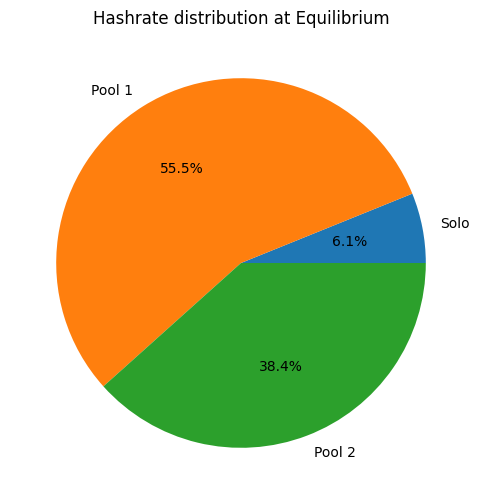

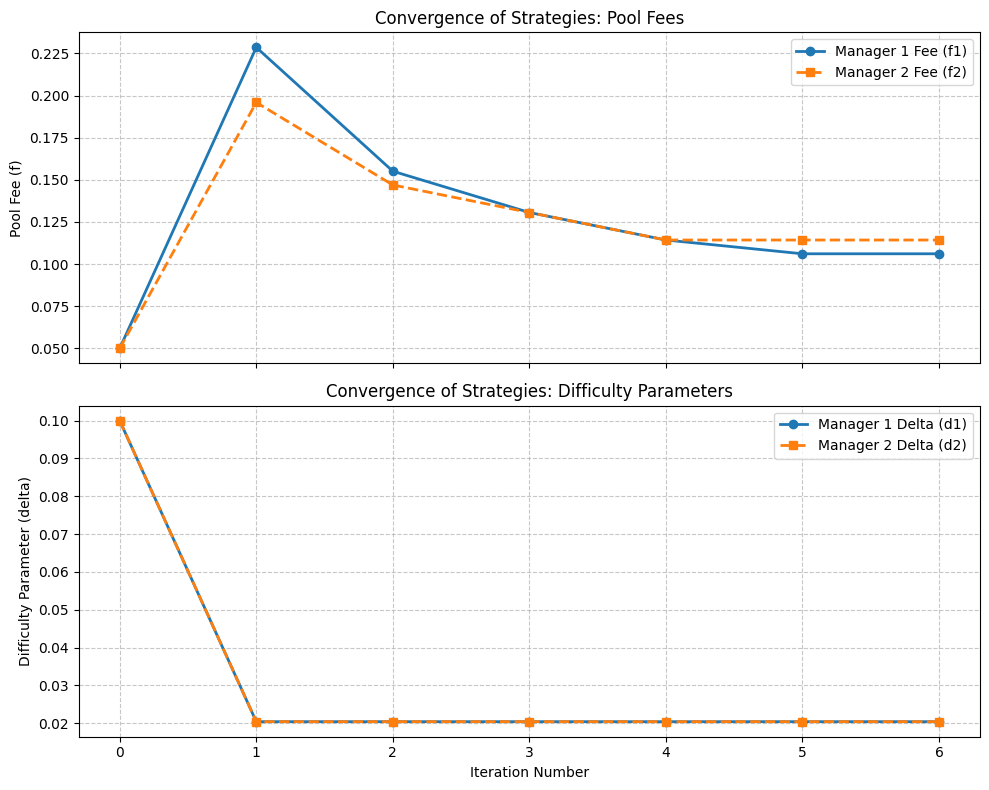

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(12345)

# ----------------------
# 0) Paramètres

# Lambda_total : intensité totale de minage (somme des λ_i)
# N_miners : nombre de mineurs hétérogènes
# alpha : paramètre Dirichlet pour répartir Λ_total
# b : reward par bloc
# eta1, eta2 : aversion au risque des managers
# y1, y2 : richesse initiale des managers
Lambda_total = 6.0
N_miners = 20        # je peux monter, mais le temps explose
alpha = 1.0
b = 3.125

eta1 = 0.01
eta2 = 0.02
y1 = 3
y2 = 5

# Mineurs : tirage des hashrates λ_i et des γ_i dans (0,1)
lambdas = rng.dirichlet(alpha * np.ones(N_miners)) * Lambda_total
theta_risk = rng.uniform(0.0, 1, size=N_miners)  # θ_i interprété comme γ_i


# ----------------------
# 1) Paramètres des "actifs" pour un mineur i

def compute_asset_params_for_miner(i, f1, d1, f2, d2):
    """
    Actifs :
      k=0 : solo,  k=1 : pool 1,  k=2 : pool 2
    """
    lam = lambdas[i]

    lam0 = lam
    lam1 = lam / d1
    lam2 = lam / d2

    b0 = b
    b1 = d1 * b * (1 - f1)
    b2 = d2 * b * (1 - f2)

    mu_vec = np.array([lam0 * b0,    lam1 * b1,      lam2 * b2])
    var_vec = np.array([lam0 * b0**2, lam1 * b1**2,  lam2 * b2**2])
    return mu_vec, var_vec


# ----------------------
# 2) Poids optimaux du mineur (w0,w1,w2)

weight_grid = np.linspace(0.0, 1.0, 21)   # 0,0.05,...,1

def miner_optimal_weights(i, f1, d1, f2, d2):
    mu_vec, var_vec = compute_asset_params_for_miner(i, f1, d1, f2, d2)
    gamma_i = float(theta_risk[i])

    best_val = -1e18
    best_w = (1.0, 0.0, 0.0)  # par défaut : tout en solo

    for w1 in weight_grid:
        for w2 in weight_grid:
            w0 = 1.0 - w1 - w2
            if w0 < 0 or w0 > 1:
                continue
            w = np.array([w0, w1, w2])

            mean_val = float(np.dot(w, mu_vec))
            var_val  = float(np.dot(w**2, var_vec))

            # critère mean–variance : E - γ Var
            obj = mean_val - gamma_i * var_val

            if obj > best_val:
                best_val = obj
                best_w = (w0, w1, w2)

    return best_w


# ----------------------
# 3) DataFrame mineurs + hashrates H_solo, H1, H2

def build_miners_df_for_contracts(f1, d1, f2, d2):
    records = []
    for i in range(N_miners):
        mu_vec, var_vec = compute_asset_params_for_miner(i, f1, d1, f2, d2)
        w0, w1, w2 = miner_optimal_weights(i, f1, d1, f2, d2)
        records.append({
            "miner_id": i,
            "lambda_i": lambdas[i],
            "gamma_i": theta_risk[i],
            "E_solo": mu_vec[0],
            "Var_solo": var_vec[0],
            "E_pool1": mu_vec[1],
            "Var_pool1": var_vec[1],
            "E_pool2": mu_vec[2],
            "Var_pool2": var_vec[2],
            "w0": w0,
            "w1": w1,
            "w2": w2,
        })

    df = pd.DataFrame(records)

    H_solo = float((df["lambda_i"] * df["w0"]).sum())
    H1     = float((df["lambda_i"] * df["w1"]).sum())
    H2     = float((df["lambda_i"] * df["w2"]).sum())

    return df, H_solo, H1, H2


# ----------------------
# 4) Utilité des managers

def manager_utility(H, f, d, eta, y0):
    if H <= 1e-12:
        return y0

    mu = H / d
    b_val = b 

    term_E = mu * (b_val * d / (1 + d)) * (f * (1 + d) - d)
    E_Y = y0 + term_E

    term1 = b_val**2 * (1 - f)**2 * d**2 / (1 + d)
    term2 = b_val**2 * d * (1 - (1 - f) * d)**2 / (1 + d)
    Var_Y = mu * (term1 + term2)

    return E_Y - eta * Var_Y


# ----------------------
# 5) Best-responses en (f,d) + Nash discret

f_grid = np.linspace(0.0, 0.4, 50)
d_grid = np.linspace(0.0, 1.0, 50)

def admissible(f, d):
    if d <= 0: 
        return False
    lhs = f * (1.0 + d)
    rhs = d
    return lhs > rhs + 1e-9


def best_response_manager(j, other_contract):
    f_other, d_other = other_contract

    best_J = -1e30
    best_f = None
    best_d = None
    best_H = (0.0, 0.0, 0.0)

    for f in f_grid:
        for d in d_grid:
            if not admissible(f, d):
                continue

            if j == 1:
                f1, d1 = f, d
                f2, d2 = f_other, d_other
            else:
                f1, d1 = f_other, d_other
                f2, d2 = f, d

            _, H_solo, H1, H2 = build_miners_df_for_contracts(f1, d1, f2, d2)

            if j == 1:
                J = manager_utility(H1, f1, d1, eta1, y1)
            else:
                J = manager_utility(H2, f2, d2, eta2, y2)

            if J > best_J:
                best_J = J
                best_f = f
                best_d = d
                best_H = (H_solo, H1, H2)

    return best_f, best_d, best_J, best_H


def solve_nash_fd(start_f1=0.05, start_d1=0.1,
                  start_f2=0.05, start_d2=0.1,
                  max_iter=20, tol=1e-3):
    f1, d1 = start_f1, start_d1
    f2, d2 = start_f2, start_d2
    history = []

    # On enregistre l'état initial (itération 0) pour que le graphique commence quelque part
    # Attention: les utilités/H ici ne sont pas calculés, on met des placeholders ou on calcule avant.
    # Pour simplifier le plot, on stocke juste les stratégies de départ.
    history.append({
        "iter": 0,
        "f1": f1, "d1": d1,
        "f2": f2, "d2": d2
    })

    for it in range(1, max_iter + 1):
        # Best response manager 1 à (f2,d2)
        br1_f, br1_d, br1_J, br1_H = best_response_manager(1, (f2, d2))
        
        # Best response manager 2 à (br1_f,br1_d) -> on utilise la nouvelle réponse de M1
        br2_f, br2_d, br2_J, br2_H = best_response_manager(2, (br1_f, br1_d))

        history.append({
            "iter": it,
            "f1": br1_f, "d1": br1_d, "J1": br1_J,
            "f2": br2_f, "d2": br2_d, "J2": br2_J,
            # On stocke aussi les H pour info
            "H_solo": br2_H[0], "H1": br2_H[1], "H2": br2_H[2] 
        })

        # critère de convergence
        if (abs(br1_f - f1) < tol and abs(br1_d - d1) < tol and
            abs(br2_f - f2) < tol and abs(br2_d - d2) < tol):
            f1, d1, f2, d2 = br1_f, br1_d, br2_f, br2_d
            break

        f1, d1, f2, d2 = br1_f, br1_d, br2_f, br2_d

    df_final, H_solo, H1, H2 = build_miners_df_for_contracts(f1, d1, f2, d2)
    J1_final = manager_utility(H1, f1, d1, eta1, y1)
    J2_final = manager_utility(H2, f2, d2, eta2, y2)

    return {
        "f1": f1, "d1": d1,
        "f2": f2, "d2": d2,
        "H_solo": H_solo, "H1": H1, "H2": H2,
        "J1": J1_final, "J2": J2_final,
        "history": history
    }


# -------------------
# MAIN : Exécution et Graphiques
if __name__ == "__main__":
    # On lance la résolution
    result = solve_nash_fd()
    
    print("-" * 40)
    print("RÉSULTATS FINAUX (Nash Equilibrium)")
    print("-" * 40)
    print(f"Pool 1 : f={result['f1']:.4f}, d={result['d1']:.4f} | J={result['J1']:.4f}")
    print(f"Pool 2 : f={result['f2']:.4f}, d={result['d2']:.4f} | J={result['J2']:.4f}")
    print(f"Hashrates : H_solo={result['H_solo']:.3f}, H1={result['H1']:.3f}, H2={result['H2']:.3f}")

    # ==========================================
    # GRAPHIQUE 1 : Camembert de répartition
    # ==========================================
    labels = ["Solo", "Pool 1", "Pool 2"]
    sizes = [result["H_solo"], result["H1"], result["H2"]]

    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct="%1.1f%%")
    plt.title("Hashrate distribution at Equilibrium")
    plt.show()

    # ==========================================
    # GRAPHIQUE 2 : Convergence des paramètres
    # ==========================================
    history = result["history"]
    
    # Extraction des données pour le plot
    iters = [h["iter"] for h in history]
    f1_traj = [h["f1"] for h in history]
    d1_traj = [h["d1"] for h in history]
    f2_traj = [h["f2"] for h in history]
    d2_traj = [h["d2"] for h in history]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plot des Frais (f)
    ax1.plot(iters, f1_traj, 'o-', linewidth=2, label='Manager 1 Fee (f1)')
    ax1.plot(iters, f2_traj, 's--', linewidth=2, label='Manager 2 Fee (f2)')
    ax1.set_ylabel('Pool Fee (f)')
    ax1.set_title('Convergence of Strategies: Pool Fees')
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend()

    # Plot de la Difficulté (d)
    ax2.plot(iters, d1_traj, 'o-', linewidth=2, label='Manager 1 Delta (d1)')
    ax2.plot(iters, d2_traj, 's--', linewidth=2, label='Manager 2 Delta (d2)')
    ax2.set_ylabel('Difficulty Parameter (delta)')
    ax2.set_xlabel('Iteration Number')
    ax2.set_title('Convergence of Strategies: Difficulty Parameters')
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend()

    plt.tight_layout()
    plt.show()

Début de la boucle d'itérations (cela peut prendre un peu de temps)...
-> Convergence détectée à l'itération 6, mais on continue pour le graphique...
-> Convergence détectée à l'itération 7, mais on continue pour le graphique...
-> Convergence détectée à l'itération 8, mais on continue pour le graphique...
-> Convergence détectée à l'itération 9, mais on continue pour le graphique...
-> Convergence détectée à l'itération 10, mais on continue pour le graphique...
-> Convergence détectée à l'itération 11, mais on continue pour le graphique...
-> Convergence détectée à l'itération 12, mais on continue pour le graphique...
-> Convergence détectée à l'itération 13, mais on continue pour le graphique...
-> Convergence détectée à l'itération 14, mais on continue pour le graphique...
-> Convergence détectée à l'itération 15, mais on continue pour le graphique...
-> Convergence détectée à l'itération 16, mais on continue pour le graphique...
-> Convergence détectée à l'itération 17, mais on con

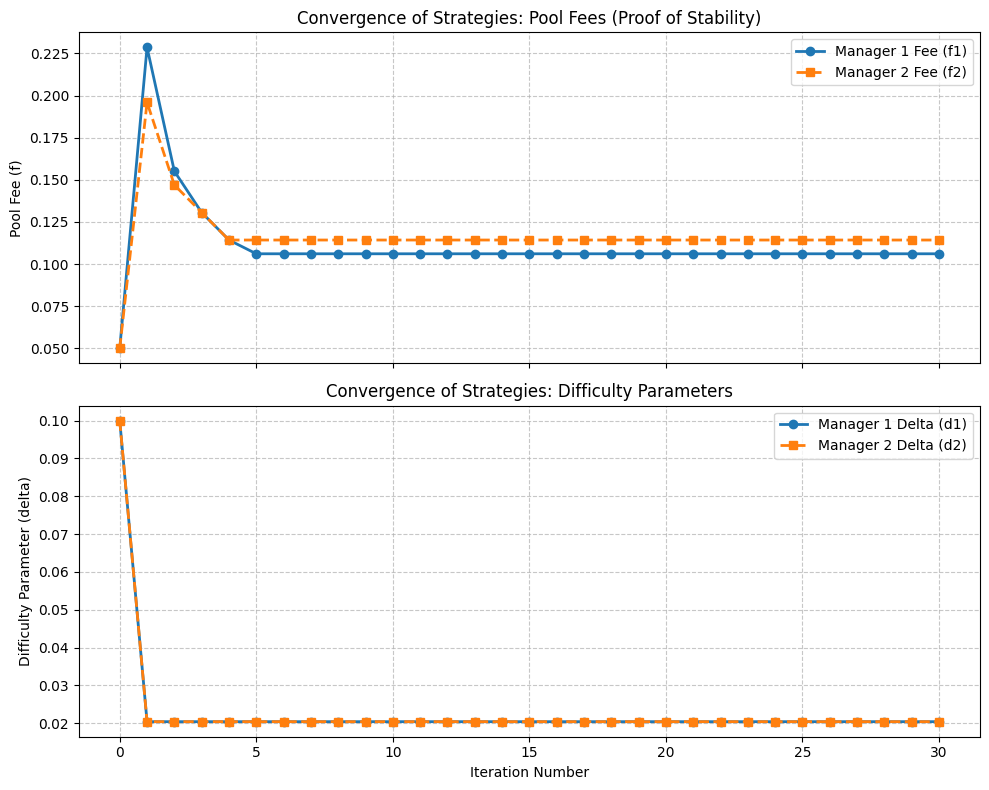

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(12345)

# ----------------------
# 0) Paramètres
Lambda_total = 6.0
N_miners = 20
alpha = 1.0
b = 3.125

eta1 = 0.01
eta2 = 0.02
y1 = 3
y2 = 5

lambdas = rng.dirichlet(alpha * np.ones(N_miners)) * Lambda_total
theta_risk = rng.uniform(0.0, 1, size=N_miners)

# ----------------------
# 1) Paramètres des "actifs"

def compute_asset_params_for_miner(i, f1, d1, f2, d2):
    lam = lambdas[i]
    lam0 = lam
    lam1 = lam / d1
    lam2 = lam / d2

    b0 = b
    b1 = d1 * b * (1 - f1)
    b2 = d2 * b * (1 - f2)

    mu_vec = np.array([lam0 * b0,    lam1 * b1,      lam2 * b2])
    var_vec = np.array([lam0 * b0**2, lam1 * b1**2,  lam2 * b2**2])
    return mu_vec, var_vec

# ----------------------
# 2) Poids optimaux

weight_grid = np.linspace(0.0, 1.0, 21)

def miner_optimal_weights(i, f1, d1, f2, d2):
    mu_vec, var_vec = compute_asset_params_for_miner(i, f1, d1, f2, d2)
    gamma_i = float(theta_risk[i])

    best_val = -1e18
    best_w = (1.0, 0.0, 0.0)

    for w1 in weight_grid:
        for w2 in weight_grid:
            w0 = 1.0 - w1 - w2
            if w0 < 0 or w0 > 1:
                continue
            w = np.array([w0, w1, w2])
            mean_val = float(np.dot(w, mu_vec))
            var_val  = float(np.dot(w**2, var_vec))
            obj = mean_val - gamma_i * var_val
            if obj > best_val:
                best_val = obj
                best_w = (w0, w1, w2)
    return best_w

# ----------------------
# 3) DataFrame & Hashrates

def build_miners_df_for_contracts(f1, d1, f2, d2):
    records = []
    for i in range(N_miners):
        mu_vec, var_vec = compute_asset_params_for_miner(i, f1, d1, f2, d2)
        w0, w1, w2 = miner_optimal_weights(i, f1, d1, f2, d2)
        records.append({
            "miner_id": i,
            "lambda_i": lambdas[i],
            "w0": w0, "w1": w1, "w2": w2,
        })
    df = pd.DataFrame(records)
    H_solo = float((df["lambda_i"] * df["w0"]).sum())
    H1     = float((df["lambda_i"] * df["w1"]).sum())
    H2     = float((df["lambda_i"] * df["w2"]).sum())
    return df, H_solo, H1, H2

# ----------------------
# 4) Utilité Manager

def manager_utility(H, f, d, eta, y0):
    if H <= 1e-12: return y0
    mu = H / d
    b_val = b 
    term_E = mu * (b_val * d / (1 + d)) * (f * (1 + d) - d)
    E_Y = y0 + term_E
    term1 = b_val**2 * (1 - f)**2 * d**2 / (1 + d)
    term2 = b_val**2 * d * (1 - (1 - f) * d)**2 / (1 + d)
    Var_Y = mu * (term1 + term2)
    return E_Y - eta * Var_Y

# ----------------------
# 5) Best-responses & Nash

f_grid = np.linspace(0.0, 0.4, 50)
d_grid = np.linspace(0.0, 1.0, 50)

def admissible(f, d):
    if d <= 0: return False
    return f * (1.0 + d) > d + 1e-9

def best_response_manager(j, other_contract):
    f_other, d_other = other_contract
    best_J = -1e30
    best_f = None
    best_d = None
    best_H = (0.0, 0.0, 0.0)

    for f in f_grid:
        for d in d_grid:
            if not admissible(f, d): continue
            
            if j == 1:
                f1, d1 = f, d
                f2, d2 = f_other, d_other
            else:
                f1, d1 = f_other, d_other
                f2, d2 = f, d
            
            _, H_solo, H1, H2 = build_miners_df_for_contracts(f1, d1, f2, d2)
            
            if j == 1: J = manager_utility(H1, f1, d1, eta1, y1)
            else:      J = manager_utility(H2, f2, d2, eta2, y2)
            
            if J > best_J:
                best_J = J
                best_f, best_d = f, d
                best_H = (H_solo, H1, H2)
    return best_f, best_d, best_J, best_H

def solve_nash_fd(start_f1=0.05, start_d1=0.1,
                  start_f2=0.05, start_d2=0.1,
                  max_iter=30, tol=1e-3): # <--- J'ai augmenté max_iter à 30
    
    f1, d1 = start_f1, start_d1
    f2, d2 = start_f2, start_d2
    history = []

    history.append({
        "iter": 0, "f1": f1, "d1": d1, "f2": f2, "d2": d2
    })

    print("Début de la boucle d'itérations (cela peut prendre un peu de temps)...")

    for it in range(1, max_iter + 1):
        br1_f, br1_d, br1_J, br1_H = best_response_manager(1, (f2, d2))
        br2_f, br2_d, br2_J, br2_H = best_response_manager(2, (br1_f, br1_d))

        history.append({
            "iter": it,
            "f1": br1_f, "d1": br1_d, "J1": br1_J,
            "f2": br2_f, "d2": br2_d, "J2": br2_J,
            "H_solo": br2_H[0], "H1": br2_H[1], "H2": br2_H[2] 
        })

        # --- MODIFICATION ICI ---
        # On vérifie la convergence pour l'affichage, mais on NE break PAS.
        # Cela force l'algo à continuer pour tracer le "plateau" stable.
        if (abs(br1_f - f1) < tol and abs(br1_d - d1) < tol and
            abs(br2_f - f2) < tol and abs(br2_d - d2) < tol):
            print(f"-> Convergence détectée à l'itération {it}, mais on continue pour le graphique...")
            # On ne met pas 'break' ici
        
        f1, d1, f2, d2 = br1_f, br1_d, br2_f, br2_d

    df_final, H_solo, H1, H2 = build_miners_df_for_contracts(f1, d1, f2, d2)
    J1_final = manager_utility(H1, f1, d1, eta1, y1)
    J2_final = manager_utility(H2, f2, d2, eta2, y2)

    return {
        "f1": f1, "d1": d1, "f2": f2, "d2": d2,
        "H_solo": H_solo, "H1": H1, "H2": H2,
        "J1": J1_final, "J2": J2_final,
        "history": history
    }

# -------------------
# MAIN
if __name__ == "__main__":
    result = solve_nash_fd()
    
    print("-" * 40)
    print("RÉSULTATS FINAUX")
    print("-" * 40)
    print(f"Pool 1 : f={result['f1']:.4f}, d={result['d1']:.4f}")
    print(f"Pool 2 : f={result['f2']:.4f}, d={result['d2']:.4f}")

    # ==========================================
    # GRAPHIQUE 2 : Convergence des paramètres (Longue traîne)
    # ==========================================
    history = result["history"]
    
    iters = [h["iter"] for h in history]
    f1_traj = [h["f1"] for h in history]
    d1_traj = [h["d1"] for h in history]
    f2_traj = [h["f2"] for h in history]
    d2_traj = [h["d2"] for h in history]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plot des Frais (f)
    ax1.plot(iters, f1_traj, 'o-', linewidth=2, label='Manager 1 Fee (f1)')
    ax1.plot(iters, f2_traj, 's--', linewidth=2, label='Manager 2 Fee (f2)')
    ax1.set_ylabel('Pool Fee (f)')
    ax1.set_title('Convergence of Strategies: Pool Fees (Proof of Stability)')
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend()

    # Plot de la Difficulté (d)
    ax2.plot(iters, d1_traj, 'o-', linewidth=2, label='Manager 1 Delta (d1)')
    ax2.plot(iters, d2_traj, 's--', linewidth=2, label='Manager 2 Delta (d2)')
    ax2.set_ylabel('Difficulty Parameter (delta)')
    ax2.set_xlabel('Iteration Number')
    ax2.set_title('Convergence of Strategies: Difficulty Parameters')
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend()

    plt.tight_layout()
    plt.show()